In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
module_path = Path("..").resolve().as_posix()
if module_path not in sys.path:
    print(f"Adding {module_path} to python path")
    sys.path.append(module_path)

Adding /home/rav/projects/gwas-analysis/notebooks/platform/xarray to python path


In [8]:
import lib.io.pysnptools_backend
from lib.method.pc_relate.pc_relate import pc_relate

In [19]:
from lib import api
import pandas as pd
import numpy as np
from dask_ml.decomposition import PCA
import dask
import dask.array as da
import seaborn as sns
import time
from distributed import Client

In [32]:
sns.set(style="darkgrid")
from IPython.core.pylabtools import figsize
figsize(14, 7)

In [5]:
# This data was generated via hail using Balding-Nichols model: samples=1000, variants=5000, populations=3
path = Path(f"{Path.home()}/projects/tmp/plink_s_1000_v_5000_p_3/data").as_posix()

ds = api.read_plink(path, chunks='auto', fam_sep=' ', bim_sep='\t')
g = ds.data.data
g

In [13]:
def get_plink(s):
    path = Path(f"{Path.home()}/projects/tmp/plink_{s}/data").as_posix()
    ds = api.read_plink(path, chunks='auto', fam_sep=' ', bim_sep='\t')
    return ds.data.data

In [24]:
def compute_pca(g, display_pc_12: bool=True):
    pca = PCA(n_components=8, random_state=42)
    pca.fit(g)
    if display_pc_12:
        display(sns.scatterplot(x=pca.components_[0], y=pca.components_[1]))
    pcs = da.from_array(pca.components_)
    return pcs[:2,:]

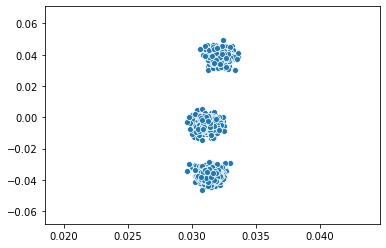

In [7]:
pcs = compute_pca(g)

In [12]:
%%timeit -n 4 -r 4
phi = pc_relate(pcs, g).compute()

610 ms ± 40.5 ms per loop (mean ± std. dev. of 4 runs, 4 loops each)


s: 1000, time: 0.28 sec


s: 2000, time: 0.64 sec


s: 4000, time: 2.39 sec


s: 6000, time: 6.52 sec


s: 8000, time: 12.27 sec


s: 10000, time: 21.43 sec


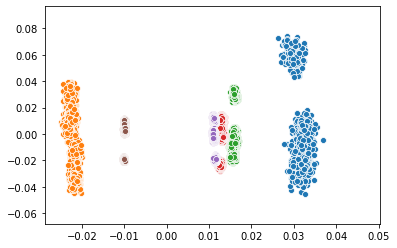

In [17]:
for i in [1000, 2000, 4000, 6000, 8000, 10000]:
    g = get_plink(i)
    pcs = compute_pca(g)
    t_0 = time.time()
    pc_relate(pcs, g).compute()
    print(f"s: {i}, time: {time.time() - t_0:.2f} sec")

In [20]:
c = Client(processes=True)

In [25]:
times = []
with dask.config.set({"optimization.fuse.ave-width": 20}):
    for i in [1000, 2000, 4000, 6000, 8000, 10000]:
        g = get_plink(i)
        pcs = compute_pca(g, False)
        t_0 = time.time()
        pc_relate(pcs, g).compute()
        dur = time.time() - t_0
        times.append((i, dur))
        print(f"s: {i}, time: {dur:.2f} sec")

s: 1000, time: 0.59 sec
s: 2000, time: 0.86 sec
s: 4000, time: 2.87 sec
s: 6000, time: 6.94 sec
s: 8000, time: 13.65 sec
s: 10000, time: 22.81 sec


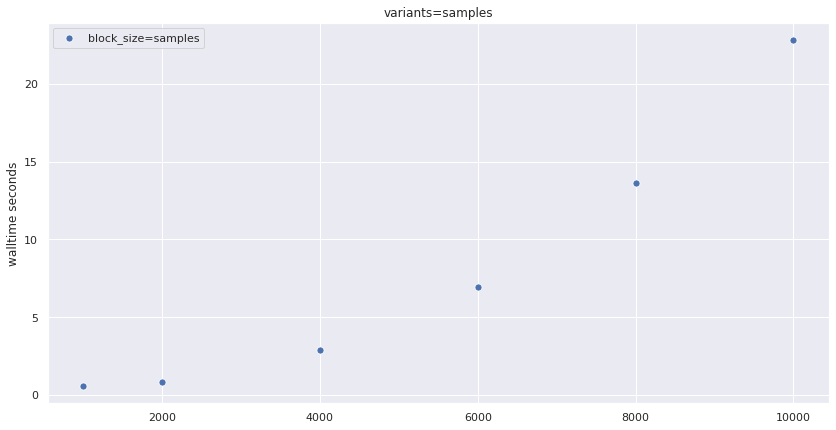

In [34]:
x = [i[0] for i in times]
y = [i[1] for i in times]
p = sns.scatterplot(x=x, y=y, s=50)
p.set(ylabel="walltime seconds", title="variants=samples")
p.legend(["block_size=samples", "block_size=2cores", "block_size=3cores", "block_size=4cores", "block_size=8cores", "block_size=512"])